<a href="https://colab.research.google.com/github/sshukl21/MAE-598-Projects/blob/main/MAE_598_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 1: Rocket Landing With Differentiable Programming
### Problem Statement
In this project, we introduce three new elements to make the problem more reflective of real-world scenarios:

1. Incorporating drag force into the dynamic function
2. Accounting for variability in initial state distribution
3. Introducing noise in both state and dynamics

For model simplification, we consider a scenario where the rocket descends vertically, taking into account gravity, thrust, and drag forces. The diagram below illustrates the motion of the rocket and the force diagram. The state and dynamic function can be described as follows:
$$
\begin{aligned}
\quad &x_{t+1} = x_{t} + v_{t}\Delta t + w_{t} \\
\quad &v_{t+1} = v_{t} + (g_{gravity} + (a_{drag}-a_{thrust})a_{t})\Delta t + u_{t} \\
\quad &a_{t} = NN_{\theta}(x_{t})
\end{aligned}
$$
where $x_{t}$ denotes the rocket's position at time $t$, $v_{t}$ represents the rocket's velocity at time $t$, $g_{gravity}$ is the gravitational acceleration (set as 0.12), $a_{drag}$ is the drag coefficient (set as 0.005), $a_{thrust}$ is the thrust coefficient (set as 0.205), $\Delta t$ is the time step (set as 0.095), $w_{t}$ and $u_{t}$ are noise terms for the state and dynamic function at time $t$, respectively. $a_{t}$ is the action derived from a neural network fed by $x_{t}$, and $\theta$ are the neural network's parameters.

The initial position is uniformly distributed, and all initial velocities are set to zero. In our experiment, we randomly select 30 initial states from this distribution.

The objective function is defined as:
$$
\begin{aligned}
\quad &f = x_{T}^2 + v_{T}^2
\end{aligned}
$$
where $T$ is the time at which the rocket lands.

Therefore, our goal is to minimize the objective function considering the distribution of the initial state:
$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}_{T}||^2 + ||v^{(i)}_{T}||^2 \\
\quad &x^{(i)}_{t+1} = x^{(i)}_{t} + v^{(i)}_{t}\Delta t + w^{(i)}_{t} \\
\quad &v^{(i)}_{t+1} = v^{(i)}_{t} + (g_{gravity} + (a_{drag}-a_{thrust})a^{(i)}_{t})\Delta t + u^{(i)}_{t} \\
\quad &a_{t}^{(i)} = NN_{\theta}(x^{(i)}_{t}), \forall t=1,...,T-1, \forall i=1,...,N\\
\quad & T = 100, N = 30\\
\end{aligned}
$$

### Programming

In [ ]:
%matplotlib inline
# This line ensures that the matplotlib plots will be displayed inline.
import logging
# Imports the logging module to enable logging of events and errors.
import numpy as np
# Imports the NumPy library for numerical operations.
import torch as t
# Imports the PyTorch library for tensors and deep learning.
import torch.nn as nn
# Imports the neural network module from PyTorch for building the network layers.
from torch import optim
# Imports the optimization algorithms from PyTorch, used in training neural networks.
import matplotlib.pyplot as plt
# Imports the matplotlib library for plotting graphs.

logger = logging.getLogger(__name__)
# Sets up a logger for this script to log messages.

# Environment parameters

FRAME_TIME = 0.095  # Sets the frame time interval.
GRAVITY_ACCEL = 0.12  # Defines the acceleration due to gravity.
BOOST_ACCEL = 0.205  # Sets the acceleration due to thrust.
DRAG_ACCEL = 0.005  # Defines the acceleration due to drag.

class Dynamics(nn.Module):
# Defines a class for the rocket's dynamics, extending PyTorch's Module class.

    def __init__(self):# Initializes the Dynamics class.
        super(Dynamics, self).__init__()

    def forward(self, state, action, Noise, mean, variance):
      # Defines the forward pass for the dynamics model.
      # state: the current state of the rocket.
      # action: the action (thrust or not).
      # Noise: boolean indicating whether to add noise.
      # mean, variance: parameters for the noise.

        """
        action: thrust or not thrust
        state[0] = y
        state[1] = y_dot
        """
        # Gravity effect
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])
        # Computes the change in state due to gravity.

        # Thrust and drag effect
        delta_state = (DRAG_ACCEL - BOOST_ACCEL) * FRAME_TIME * t.tensor([0., 1.]) * action
        # Computes the change in state due to thrust and drag.

        # Noise addition
        w = t.tensor([1, 0]) * t.tensor(np.random.normal(mean, variance, 1))
        u = t.tensor([0, 1]) * t.tensor(np.random.normal(mean, variance, 1))
        noise = w + u
        # Generates noise to be added to the state.

        # State update
        state = state + delta_state + delta_state_gravity
        # Updates the state with gravity, thrust/drag, and noise.

        # Transformation matrix application
        step_mat = t.tensor([[1., 0.],
                             [FRAME_TIME, 1.]])
        if Noise == True:
            state = t.matmul(state, step_mat) + noise.float()
        else:
            state = t.matmul(state, step_mat)
        # Applies a transformation matrix to the state and adds noise if required.

        return state

class Controller(nn.Module):
  # Defines the Controller class responsible for deciding the rocket's action.

    def __init__(self, dim_input, dim_hidden, dim_output):

        """
        Initializes the Controller with the given dimensions.
        dim_input: Number of input features (state variables).
        dim_output: Number of output features (action variables).
        dim_hidden: Number of neurons in the hidden layer.
        """
        super(Controller, self).__init__()
        # Initialize the parent class.

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())
        # Defines the neural network with one hidden layer and activation functions.

    def forward(self, state):
        # Defines the forward pass for the controller.
        action = self.network(state)
        # Computes the action based on the current state.
        return action

class Simulation(nn.Module):
  # Defines the Simulation class to simulate the rocket landing.

    def __init__(self, controller, dynamics, T, is_Noise, mean, variance):
        """
        Initializes the Simulation with controller, dynamics, and other parameters.
        controller: The controller object.
        dynamics: The dynamics object.
        T: Number of time steps in the simulation.
        is_Noise: Boolean indicating if noise is to be considered.
        mean, variance: Parameters for noise generation.
        """
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        # Initialize the simulation state.
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        self.is_Noise = is_Noise
        self.mean = mean
        self.variance = variance
        # Set the controller, dynamics, and other parameters.


    def forward(self, state):
        # Defines the forward pass for the simulation.
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            # Computes the action for the current state.
            state = self.dynamics(state, action, self.is_Noise, self.mean, self.variance)
            # Updates the state based on the dynamics and the action.
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)
        # Stores the action and state trajectories.

    @staticmethod
    def initialize_state():
        # Static method to initialize the simulation state.
        state = np.ones((30, 2))
        for i in range(state.shape[0]):
            state[i][0] = np.random.uniform(1, 2.5, 1)
            state[i][1] = 0
        return t.tensor(state, requires_grad=False).float()
        # Initializes the state with random values for position and zero for velocity.

    def error(self, state):
        # Defines a method to compute the error of the state.
        return t.mean(state ** 2)
        # Returns the mean squared error of the state.

class Optimize:
    # Defines the Optimize class to train and optimize the controller.

    def __init__(self, simulation):
        # Initialize the Optimize class with a Simulation object.
        self.simulation = simulation
        # Store the simulation object.
        self.parameters = simulation.controller.parameters()
        # Retrieve parameters of the controller for optimization.
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)# was 0.01
        # Initialize the LBFGS optimizer with the controller parameters.
        self.loss_list = []
        # Initialize a list to store the loss values during training.

    def step(self):
        # Defines a step in the optimization process.
        def closure():
            # Defines a closure function for the optimizer.
            loss = self.simulation(self.simulation.state)
            # Compute the loss using the current state in the simulation.
            self.optimizer.zero_grad()
            # Reset gradients to zero.
            loss.backward()
            # Perform backpropagation to compute gradients.
            return loss
            # Return the computed loss.

        self.optimizer.step(closure)
        # Perform an optimization step.
        return closure()

    def train(self, epochs):
        # Defines the training process.
        for epoch in range(epochs):
            # Iterate over the specified number of epochs.
            loss = self.step()
            # Perform an optimization step and get the loss.
            self.loss_list.append(loss)
            # Append the loss to the loss list.
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            # Print the epoch number and the loss.
        self.visualize()
        # Call the visualize method after training.

    def visualize(self):
        # Defines a method for visualizing the results.
        data = np.array([[self.simulation.state_trajectory[i][j].detach().numpy() for i in range(self.simulation.T)] for j in range(30)])
        # Extract and prepare state trajectory data for visualization.
        for i in range(30):
            # Iterate over the data to plot trajectories.
            x = data[i, :, 0]
            y = data[i, :, 1]
            plt.plot(x, y)
            # Plot the x and y components of the trajectory.
        plt.title('Position and Velocity Changeable for Rocket Landing')
        plt.xlabel('Rocket Position(m)')
        plt.ylabel('Rocket Velocity(m/s)')
        plt.show()
        # Display the plot with labels and title.

### Result and Discussion
Initially, the state and dynamic function are evaluated without any noise interference. The objective function's goal is to ensure a safe landing of the rocket at the final time, implying that the rocket's final position must equal 0. Additionally, it is desirable for the rocket's final velocity to be near 0. The accompanying figure illustrates the rocket's trajectory in terms of position and velocity. It is observed that the trajectories converge to 0 on the X-axis (representing rocket position) and approach 0 on the Y-axis (indicating rocket velocity), indicating that the controller successfully fulfills the design criteria. The convergence curve further confirms the minimization of the objective function.

[1] loss: 0.879
[2] loss: 0.498
[3] loss: 0.338
[4] loss: 0.231
[5] loss: 0.166
[6] loss: 0.133
[7] loss: 0.112
[8] loss: 0.097
[9] loss: 0.084
[10] loss: 0.071
[11] loss: 0.057
[12] loss: 0.046
[13] loss: 0.034
[14] loss: 0.025
[15] loss: 0.016
[16] loss: 0.010
[17] loss: 0.008
[18] loss: 0.006
[19] loss: 0.004
[20] loss: 0.004
[21] loss: 0.003
[22] loss: 0.002
[23] loss: 0.002
[24] loss: 0.002
[25] loss: 0.001
[26] loss: 0.001
[27] loss: 0.001
[28] loss: 0.001
[29] loss: 0.001
[30] loss: 0.001
[31] loss: 0.001
[32] loss: 0.001
[33] loss: 0.001
[34] loss: 0.001
[35] loss: 0.001


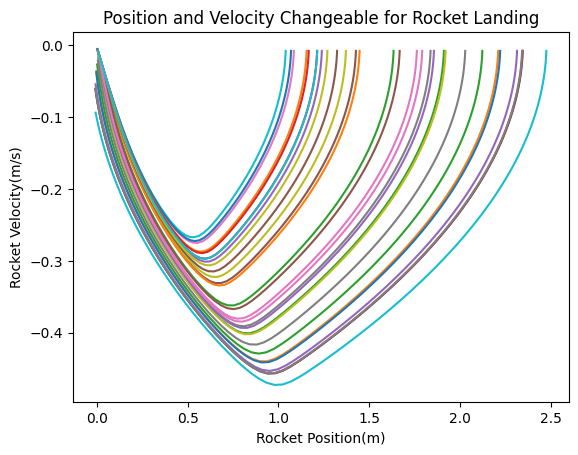

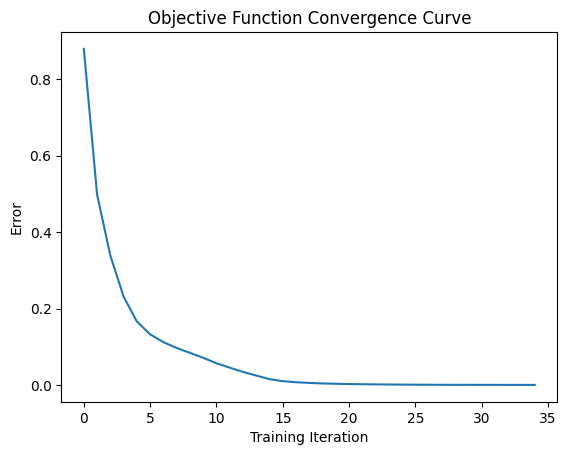

In [ ]:
T = 100  # Defines the number of time steps for the simulation.
dim_input = 2  # Sets the dimension of the state space (position and velocity).
dim_hidden = 8  # Specifies the number of neurons in the hidden layer of the controller.
dim_output = 1  # Sets the dimension of the action space (thrust/no thrust).
is_Noise = False # Indicates whether to include noise in the dynamics.
mean, variance = (0, 1e-4) # Sets the mean and variance for the noise.
d = Dynamics()  # Instantiates the Dynamics object.
c = Controller(dim_input, dim_hidden, dim_output)  # Instantiates the Controller with specified dimensions.
s = Simulation(c, d, T, is_Noise, mean, variance)  # Creates the Simulation with the controller, dynamics, and other parameters.
o = Optimize(s)  # Instantiates the Optimize object with the simulation.
o.train(35) # Trains the model for 35 epochs.

# Plotting the Objective Function Convergence Curve
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')
loss_array = [loss_item.detach().numpy() for loss_item in o.loss_list]
# Converts the loss values to a NumPy array for plotting.
plt.plot(list(range(35)), loss_array)

plt.show() # Displays the plot.

<ipython-input-3-be02e4289451>:59: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(xdata[i], ydata[i])


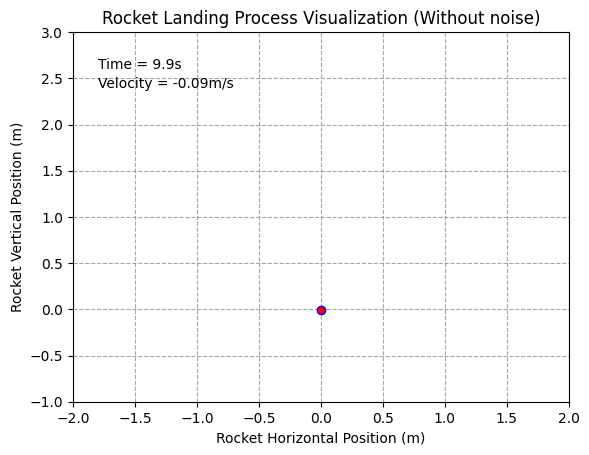

In [ ]:
import matplotlib.animation as animation
# Imports the animation module from matplotlib for creating animations.
import matplotlib.pyplot as plt
# Imports the pyplot module from matplotlib for plotting.
import numpy as np
# Imports NumPy for numerical operations.
import random
# Imports the random module for generating random numbers.


data = np.array([[s.state_trajectory[i][j].detach().numpy() for i in range(s.T)] for j in range(30)])
# Prepares the state trajectory data for animation.

n = random.sample(list(range(30)), 1)
# Randomly selects one trajectory to visualize.
ydata = data[n[0], :, 0]
xdata = np.zeros((ydata.shape[0]))
# Extracts the y-coordinate data and initializes x-coordinate data for the animation.

# Set up the figure and axis
fig, ax = plt.subplots()
# Creates a new matplotlib figure and axes.
ax.grid(True, linestyle='--', color='gray', alpha=0.7)
# Configures the grid lines on the plot.
line, = ax.plot([], [], 'o-', lw=2, color='blue', markerfacecolor='red')
# Initializes an empty line object for the animation.
time_template = 'Time = %.1fs'
velocity_template = 'Velocity = %.2fm/s'
# Templates for displaying time and velocity.
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
velocity_text = ax.text(0.05, 0.85, '', transform=ax.transAxes)
# Initializes text objects for displaying time and velocity.

def init():
    # Initialization function for the animation.
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 3)
    # Sets the x and y limits of the plot.
    ax.set_xlabel('Rocket Horizontal Position (m)')
    ax.set_ylabel('Rocket Vertical Position (m)')
    ax.set_title('Rocket Landing Process Visualization (Without noise)')
    # Sets labels and title for the plot.
    time_text.set_text('')
    velocity_text.set_text('')
    return line, time_text, velocity_text
    # Initializes the line and text objects.

def calculate_velocity(i):
    # Function to calculate velocity at each frame.
    if i == 0:
        return 0
    else:
        return (ydata[i] - ydata[i-1]) / 0.095
    # Calculates velocity based on change in position.

def update(i):
    # Update function for the animation.
    line.set_data(xdata[i], ydata[i])
    # Updates the line data.
    time_text.set_text(time_template % (0.1*i))
    velocity = calculate_velocity(i)
    velocity_text.set_text(velocity_template % velocity)
    return line, time_text, velocity_text
    # Updates the time and velocity text.

ani = animation.FuncAnimation(fig, update, frames=len(ydata), init_func=init, interval=50, blit=True)
# Creates the animation object.
ani.save('rocket landing without noise.gif', fps=30, writer='imagemagick')
# Saves the animation as a GIF file.
plt.show()
# Displays the animation.

Subsequently, we introduce noise into the state and dynamic function. We utilize a Gaussian Distribution for selecting the noise values randomly. Given that the noise range (with a mean of 0 and a variance of $10^{-4}$) is relatively minor, it is anticipated that the trajectory will be comparable to the scenario without noise. The accompanying figure corroborates our assumption, indicating that the controller remains effective even with minimal disturbance. Observing the convergence curve, it is evident that the objective function reaches minimization.

[1] loss: 2.451
[2] loss: 1.032
[3] loss: 0.577
[4] loss: 0.208
[5] loss: 0.182
[6] loss: 0.173
[7] loss: 0.106
[8] loss: 0.109
[9] loss: 0.104
[10] loss: 0.104
[11] loss: 0.051
[12] loss: 0.051
[13] loss: 0.051
[14] loss: 0.050
[15] loss: 0.038
[16] loss: 0.037
[17] loss: 0.037
[18] loss: 0.037
[19] loss: 0.029
[20] loss: 0.024
[21] loss: 0.020
[22] loss: 0.017
[23] loss: 0.014
[24] loss: 0.011
[25] loss: 0.007
[26] loss: 0.006
[27] loss: 0.003
[28] loss: 0.003
[29] loss: 0.030
[30] loss: 0.008
[31] loss: 0.003
[32] loss: 0.002
[33] loss: 0.002
[34] loss: 0.002
[35] loss: 0.002
[36] loss: 0.002
[37] loss: 0.002
[38] loss: 0.002
[39] loss: 0.002
[40] loss: 0.002
[41] loss: 0.002
[42] loss: 0.002
[43] loss: 0.002
[44] loss: 0.002
[45] loss: 0.002
[46] loss: 0.002
[47] loss: 0.002
[48] loss: 0.002
[49] loss: 0.002
[50] loss: 0.002
[51] loss: 0.002
[52] loss: 0.002
[53] loss: 0.002
[54] loss: 0.002
[55] loss: 0.002


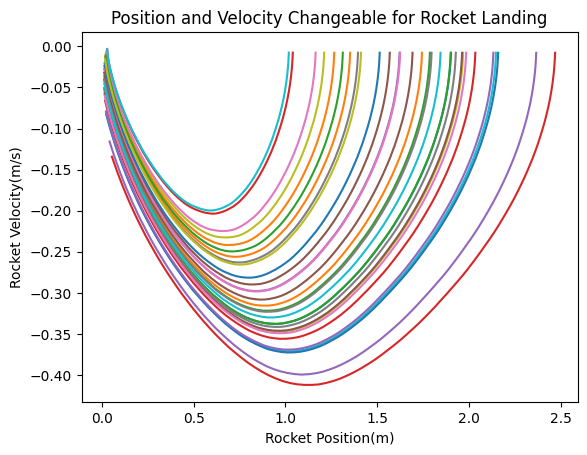

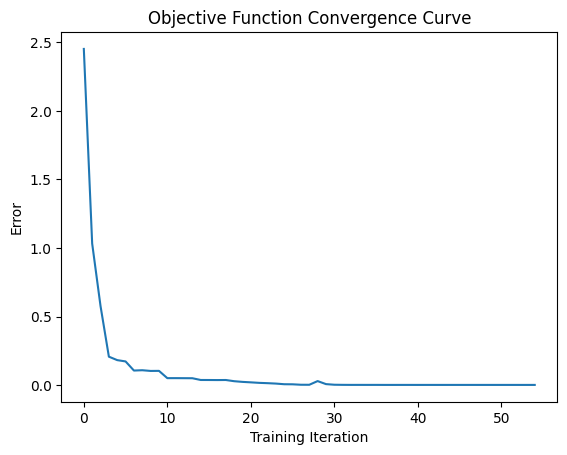

In [ ]:
T = 100  # Sets the number of time steps for the simulation.
dim_input = 2  # Dimension of the state space (e.g., position and velocity).
dim_hidden = 8  # Number of neurons in the hidden layer of the controller.
dim_output = 1  # Dimension of the action space (e.g., thrust or no thrust).
is_Noise = True # Enables noise in the dynamics of the simulation.
mean, variance = (0, 1e-4) # Sets the mean and variance for the noise.
d = Dynamics()  # Instantiates the Dynamics class.
c = Controller(dim_input, dim_hidden, dim_output)  # Instantiates the Controller class.
s = Simulation(c, d, T, is_Noise, mean, variance)  # Creates a Simulation instance with noise.
o = Optimize(s)  # Creates an Optimize instance for training.
o.train(55) # Trains the model for 55 epochs.

# Plotting the convergence curve of the objective function with noise.
plt.title('Objective Function Convergence Curve')
plt.xlabel('Training Iteration')
plt.ylabel('Error')

loss_array = [loss_item.detach().numpy() for loss_item in o.loss_list]
# Converts the loss values to a NumPy array for plotting.
plt.plot(list(range(55)), loss_array)
# Plots the training iteration against the error.
plt.show() # Displays the plot.

We randomly choose one rocket landing trajectory with noise perturbation and present the whole rocket landing process through animation. Animation code is shown as below.   

In [ ]:
%matplotlib notebook
# Switches to an interactive matplotlib backend.
import matplotlib.animation as animation
# Imports the animation module from matplotlib for creating animations.
import matplotlib.pyplot as plt
# Imports the pyplot module from matplotlib for plotting.
import numpy as np
# Imports the NumPy library for numerical operations.
import random
# Imports the random module for generating random numbers.


data = np.array([[s.state_trajectory[i][j].detach().numpy() for i in range(s.T)] for j in range(30)])
# Extracts and prepares the state trajectory data from the simulation for animation.


n = random.sample(list(range(30)), 1)
# Randomly selects one of the 30 trajectories to visualize.
ydata = data[n[0], :, 0]
xdata = np.zeros((ydata.shape[0]))
# Extracts the y-coordinate data and sets the x-coordinate data for the animation.

# Set up the figure and axis
fig, ax = plt.subplots()
# Creates a new matplotlib figure and axes.
ax.grid(True, linestyle='--', color='gray', alpha=0.7)
# Configures the grid lines on the plot.
line, = ax.plot([], [], 'o-', lw=2, color='blue', markerfacecolor='red')
# Initializes an empty line object for the animation.
time_template = 'Time = %.1fs'
velocity_template = 'Velocity = %.2fm/s'
# Templates for displaying time and velocity.
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
velocity_text = ax.text(0.05, 0.85, '', transform=ax.transAxes)
# Initializes text objects for displaying time and velocity.

def init():
    # Initialization function for the animation.
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 3)
    # Sets the x and y limits of the plot.
    ax.set_xlabel('Rocket Horizontal Position (m)')
    ax.set_ylabel('Rocket Vertical Position (m)')
    ax.set_title('Rocket Landing Process Visualization (Noise involved)')
    # Sets labels and title for the plot.
    time_text.set_text('')
    velocity_text.set_text('')
    return line, time_text, velocity_text
    # Initializes the line and text objects.

def calculate_velocity(i):
    # Function to calculate velocity at each frame.
    if i == 0:
        return 0
    else:
        return (ydata[i] - ydata[i-1]) / 0.095
    # Calculates velocity based on the change in position.

def update(i):
    # Update function for the animation.
    line.set_data(xdata[i], ydata[i])
    # Updates the line data.
    time_text.set_text(time_template % (0.1*i))
    velocity = calculate_velocity(i)
    velocity_text.set_text(velocity_template % velocity)
    return line, time_text, velocity_text
    # Updates the time and velocity text.

ani = animation.FuncAnimation(fig, update, frames=len(ydata), init_func=init, interval=50, blit=True)
# Creates the animation object.
ani.save('rocket landing with noise.gif', fps=30, writer='imagemagick')
# Saves the animation as a GIF file.
plt.show()
# Displays the animation.

<IPython.core.display.Javascript object>

<ipython-input-5-9a26ea95bad3>:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(xdata[i], ydata[i])


This experiment demonstrates that the existing controller performs effectively with the specified initial distribution, even under minor noise disturbances.